# 출처: https://wikidocs.net/22933

# 1. 데이터 확인

In [1]:
from tensorflow.keras.datasets import reuters
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import numpy as np
# save np.load
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a: np_load_old(*a, allow_pickle=True)

(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

# restore np.load for future normal usage
np.load = np_load_old

In [3]:
print('훈련용 뉴스 기사 : {}'.format(len(X_train)))
print('테스트용 뉴스 기사 : {}'.format(len(X_test)))
# y_train의 카테고리가 0부터 시작하기 때문에 최댓값에 +1을 해준다.
num_classes = max(y_train) + 1
print('카테고리 : {}'.format(num_classes))

훈련용 뉴스 기사 : 8982
테스트용 뉴스 기사 : 2246
카테고리 : 46


In [4]:
print(X_train[0]) # X_train의 인덱스는 자주 등장할수록 작은 숫자 부여
print(y_train[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3


In [5]:
print('뉴스 기사의 최대 길이 : {}'.format(max(len(l) for l in X_train)))
print('뉴스 기사의 평균 길이 : {}'.format(sum(len(l) for l in X_train)/len(X_train)))

뉴스 기사의 최대 길이 : 2376
뉴스 기사의 평균 길이 : 145.5398574927633


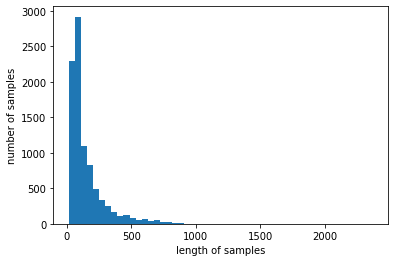

In [8]:
plt.hist([len(s) for s in X_train], bins = 50) # legnth 50마다 쪼개서 결과 보여줌
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

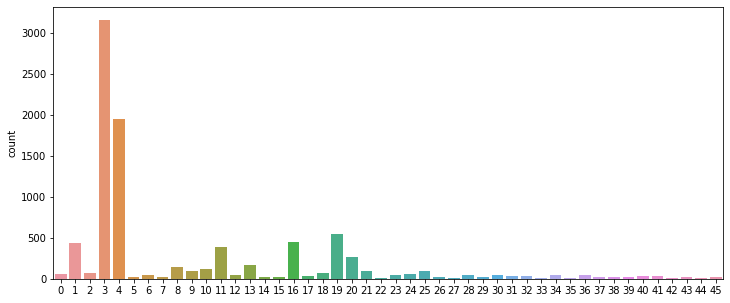

In [9]:
# 카테고리별 뉴스의 갯수 분포 >> 대부분 3,4번 카테고리에 편중되어있음
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train)dnldml 

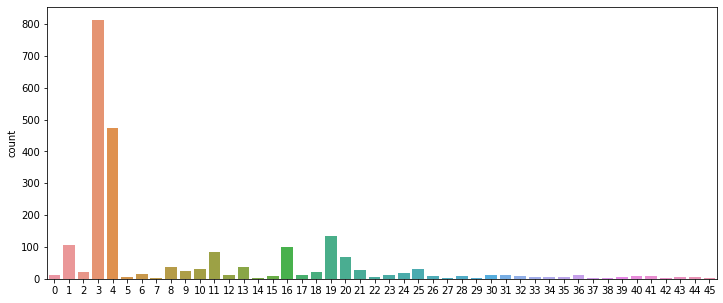

In [17]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_test)

In [10]:
unique_elements, counts_elements = np.unique(y_train, return_counts = True)
print('각 레이블에 대한 빈도수:')
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [11]:
label_cnt = dict(zip(unique_elements, counts_elements))
print(label_cnt)

{0: 55, 1: 432, 2: 74, 3: 3159, 4: 1949, 5: 17, 6: 48, 7: 16, 8: 139, 9: 101, 10: 124, 11: 390, 12: 49, 13: 172, 14: 26, 15: 20, 16: 444, 17: 39, 18: 66, 19: 549, 20: 269, 21: 100, 22: 15, 23: 41, 24: 62, 25: 92, 26: 24, 27: 15, 28: 48, 29: 19, 30: 45, 31: 39, 32: 32, 33: 11, 34: 50, 35: 10, 36: 49, 37: 19, 38: 19, 39: 24, 40: 36, 41: 30, 42: 13, 43: 21, 44: 12, 45: 18}


In [12]:
word_to_index = reuters.get_word_index()
#print(word_to_index)

557056/550378 [==============================] - 0s 1us/step


In [14]:
index_to_word = {}  # dictionary
for key, value in word_to_index.items():
    index_to_word[value] = key

In [15]:
print('빈도수 상위 {}번 단어 : {}'.format(3, index_to_word[3]))

빈도수 상위 3번 단어 : to


In [16]:
print(' '.join([index_to_word[X] for X in X_train[9]]))

the 6 hurting up as combined months 3198 and matter for such thomas said relatively britain level one month assets few a what one when fell mln months central 168 for sept said costs is relatively britain and production is relatively means month for assets reduce note was hurting it before on treasury april announced in fell mln in stabilized sept cts foreign is britain level and account is means months however it britain level one as results along currency in rates expected silently part anza qtrs common in week's convert purchase have five acceptances deposits was regime said britain richard 3 disapproval venice pct dlrs


# 2. LSTM으로 로이터 뉴스 분류하기

In [19]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [20]:
# 빈도수 1000까지의 단어만 사용
np_load_old = np.load
np.load = lambda *a: np_load_old(*a, allow_pickle=True)
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)
np.load = np_load_old

In [21]:
# 모든 데이터의 길이는 100으로 통일
max_len = 100
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [22]:
# 레이블은 원핫 인코딩
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [26]:
model = Sequential()
model.add(Embedding(1000, 120))
model.add(LSTM(120))
model.add(Dense(46, activation='softmax'))

W0528 18:02:46.372071 22860 deprecation.py:506] From c:\users\yunja_kuj61s9\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0528 18:02:46.393016 22860 deprecation.py:506] From c:\users\yunja_kuj61s9\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [27]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history=model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_test, y_test))

W0528 18:15:02.063509 22860 deprecation.py:323] From c:\users\yunja_kuj61s9\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8982 samples, validate on 2246 samples
Epoch 1/30
8960/8982 [============================>.] - ETA: 0s - loss: 2.6345 - acc: 0.3461
Epoch 00001: val_acc improved from -inf to 0.36198, saving model to best_model.h5
8982/8982 [==============================] - 21s 2ms/sample - loss: 2.6333 - acc: 0.3460 - val_loss: 2.4256 - val_acc: 0.3620
Epoch 2/30
8960/8982 [============================>.] - ETA: 0s - loss: 2.3291 - acc: 0.3705
Epoch 00002: val_acc improved from 0.36198 to 0.49154, saving model to best_model.h5
8982/8982 [==============================] - 27s 3ms/sample - loss: 2.3288 - acc: 0.3705 - val_loss: 2.0299 - val_acc: 0.4915
Epoch 3/30
8960/8982 [============================>.] - ETA: 0s - loss: 1.9042 - acc: 0.5066
Epoch 00003: val_acc improved from 0.49154 to 0.53963, saving model to best_model.h5
8982/8982 [==============================] - 28s 3ms/sample - loss: 1.9034 - acc: 0.5068 - val_loss: 1.7850 - val_acc: 0.5396
Epoch 4/30
8960/8982 [=====================

In [29]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

W0528 18:27:55.284610 22860 deprecation.py:506] From c:\users\yunja_kuj61s9\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0528 18:27:55.286602 22860 deprecation.py:506] From c:\users\yunja_kuj61s9\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0528 18:27:55.287599 22860 deprecation.py:506] From c:\users\yunja_kuj61s9\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\

2246/2246 [==============================] - 2s 889us/sample - loss: 1.2109 - acc: 0.7199

 테스트 정확도: 0.7199


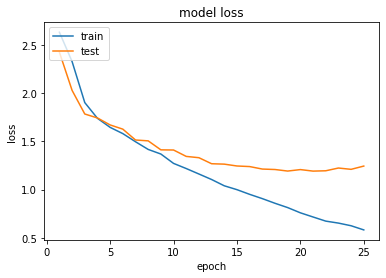

In [30]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()